# Requirement 4
## *Best-of-both-worlds algorithms with multiple products*

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

### Environment
Both stochastic environment already designed for requirement 2 and an highly non-stationary environment, where the distribution of the valuation changes **quickly** over time and the valuations are correlated together

*(Here we'll use the same class also as stochastic one, since we just need to pass the same distribution for each round)*

In [108]:
#valuations_distr is a list long T that contains for each round the multivariate normal distribution of each product
class MultipleProductHighlyNonStationaryEnvironment:
  def __init__(self, T, N, valuations_distr):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer


    # Valuation of each buyer sampled from the given distribution function:
    # TxN matrix, so for each round t we have the different valuations of each product n
    self.valuations = np.array([distr.rvs() for distr in valuations_distr])

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Agent - *Multiplicative Pacing strategy for multiple product with EXP3 as regret minimizer* **with inventory constraint** 

In [109]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [110]:
class MultipleProductMultiplicativePacingAgent:
    def __init__(self, prices_set, budget, T, N, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.eta=eta
        self.budget = budget
        self.T=T
        self.N = N

        #a different exp3 agent for every product
        self.exp3_list = [EXP3Agent(self.K, self.learning_rate) for _ in range(self.N)]

        self.lmbd = 1                               # Shared lambda
        self.t = 0
        self.N_pulls = np.zeros((self.N, self.K)) # Count arm pulls per product
        self.price_index = 0
        self._lambdas = []

    def pull_arm(self):
        if self.budget < 1:
            self.p_t = np.array([1.1 for _ in range(self.N)])
            return self.p_t

        chosen_prices = []
        for i in range(self.N):
            self.price_index = self.exp3_list[i].pull_arm()
            chosen_prices.append(self.prices_set[self.price_index])

        return chosen_prices
    def update(self, f_t_list):
        rho = self.budget/ (self.T - self.t + 1) + 2
        c_t_list= [int(f_t > 0) for f_t in f_t_list]
        c_t_tot=sum(c_t_list)

        for i in range(self.N):
          f_t=f_t_list[i]
          c_t=c_t_list[i]
          L = f_t - self.lmbd*(c_t-rho)

          # linear rescale in the feasible interval
          L_up = 1 -(1/rho)*(-rho)
          L_low = 0 -(1/rho)*(1-rho)
          rescaled_L = (L - L_low)/(L_up-L_low)
          self.exp3_list[i].update(1 - rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(rho-c_t_tot),
                            a_min=0, a_max=1/rho)

        self._lambdas.append((self.lmbd, c_t))

        #update budget
        self.budget -= c_t_tot

    def get_budget(self):
      return self.budget

    def lambdas(self):
      return self._lambdas

### Clairvoyant - **with inventory constraint**

In [111]:
class WindowedMultipleProductHighlyNonStationaryClairvoyant:
    def __init__(self, T, B, N, prices, valuations_distr, window_size=20):
        self.T = T
        self.B = B
        self.N = N
        self.prices = np.array(prices)
        self.P = len(prices)
        self.window_size = window_size
        self.valuations_distr = valuations_distr  # list of multivariate normal distributions (len=T)

    def get_selling_probabilities(self):
        # Compute the marginal selling probabilities for each product, price, and round
        marginal_cdfs = []

        for distr in self.valuations_distr:
            means = distr.mean
            variances = np.diag(distr.cov)
            prod_cdfs = []

            for i in range(self.N):
                norm_distr = stats.norm(loc=means[i], scale=np.sqrt(variances[i]))
                cdfs = norm_distr.cdf(self.prices)
                prod_cdfs.append(cdfs)

            marginal_cdfs.append(prod_cdfs)

        marginal_cdfs = np.array(marginal_cdfs)
        selling_prob = 1 - marginal_cdfs
        return selling_prob

    def run(self):
        selling_prob = self.get_selling_probabilities() 
        expected_utility = np.zeros(self.T)
        
        rho = self.B / self.T + 1.5  # Per-round budget

        M = self.T // self.window_size
        for w in range(M):
            start = w * self.window_size
            end = start + self.window_size

            avg_selling = np.mean(selling_prob[start:end], axis=0) 
            c = -(avg_selling * self.prices).reshape(-1)

            A_ub = [avg_selling.reshape(-1)]
            b_ub = [rho]

            A_eq = []
            b_eq = []
            tot_vars = self.N * self.P

            for i in range(self.N):
                eq_row = np.zeros(tot_vars)
                eq_row[i * self.P:(i + 1) * self.P] = 1
                A_eq.append(eq_row)
                b_eq.append(1)

            bounds = [(0, 1)] * tot_vars

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if res.success:
                x_w = res.x.reshape(self.N, self.P)
            else:
                x_w = np.ones((self.N, self.P)) / self.P

            # Applica strategia trovata a ogni round della finestra
            for t in range(start, end):
                util_t = np.sum(x_w * self.prices * selling_prob[t])
                expected_utility[t] = util_t

        # Handle final window
        remainder = self.T % self.window_size
        if remainder > 0:
            start = M * self.window_size
            end = self.T
            avg_selling = np.mean(selling_prob[start:end], axis=0)

            c = -(avg_selling * self.prices).reshape(-1)
            A_ub = [avg_selling.reshape(-1)]
            b_ub = [rho]

            A_eq = []
            b_eq = []
            for i in range(self.N):
                eq_row = np.zeros(self.N * self.P)
                eq_row[i * self.P:(i + 1) * self.P] = 1
                A_eq.append(eq_row)
                b_eq.append(1)

            bounds = [(0, 1)] * (self.N * self.P)

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if res.success:
                x_w = res.x.reshape(self.N, self.P)
            else:
                x_w = np.ones((self.N, self.P)) / self.P

            for t in range(start, end):
                util_t = np.sum(x_w * self.prices * selling_prob[t])
                expected_utility[t] = util_t

        return expected_utility 

### Execution - Adversarial environment

In [122]:
# Parameters
T = 10000
B = T * 75/100
N = 3

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
K = len(prices)

learning_rate = np.sqrt(np.log(K)/(K*T))  #learning rate EXP3
eta=1/np.sqrt(T)   #learing rate Multiplicative pacing

In [123]:
#Adversarial environment
valuation_distributions = []

for t in range(T):
    mean_t = np.random.uniform(0.4, 1.0, size=N)
    A = np.random.rand(N, N)
    cov_t = np.dot(A, A.T) + 0.05 * np.eye(N)
    distr = stats.multivariate_normal(mean=mean_t, cov=cov_t)
    valuation_distributions.append(distr)

In [124]:
# Run clairvoyant
clairvoyant=WindowedMultipleProductHighlyNonStationaryClairvoyant(T, B, N, prices, valuation_distributions, window_size=20)
expected_clairvoyant_utilities = clairvoyant.run()

In [125]:
prices_arr = []
rewards = []
budget_per_trial =[]
regret_per_trial = []
n_trials = 5
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductHighlyNonStationaryEnvironment(T, N, valuation_distributions)
  multiplicative_pacing_agent = MultipleProductMultiplicativePacingAgent(prices, B, T, N, eta, learning_rate)
  
  count = 0
  agent_rewards = []
  budget=[]
  for t in range(T):
    if(count>=B):
      r_t = 0
      agent_rewards.append(np.sum(r_t))
    else:
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      prices_arr.append(p_t)
      #rewards.append(r_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)

      agent_rewards.append(np.sum(r_t))
      count += np.sum(r_t > 0)
    budget.append(multiplicative_pacing_agent.get_budget())
  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)
  budget_per_trial.append(budget)

regret_per_trial = np.array(regret_per_trial)
budget_per_trial = np.array(budget_per_trial)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation
average_budget = np.array(budget_per_trial).mean(axis=0)
budget_sd = np.array(budget_per_trial).std(axis=0)

### Results

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_88769/1684471633.py:14: SyntaxWarning: invalid escape sequence '\s'
  axs[0].plot(t, theoretical_curve, label="$\sqrt{T}$", linestyle="--", color="red")


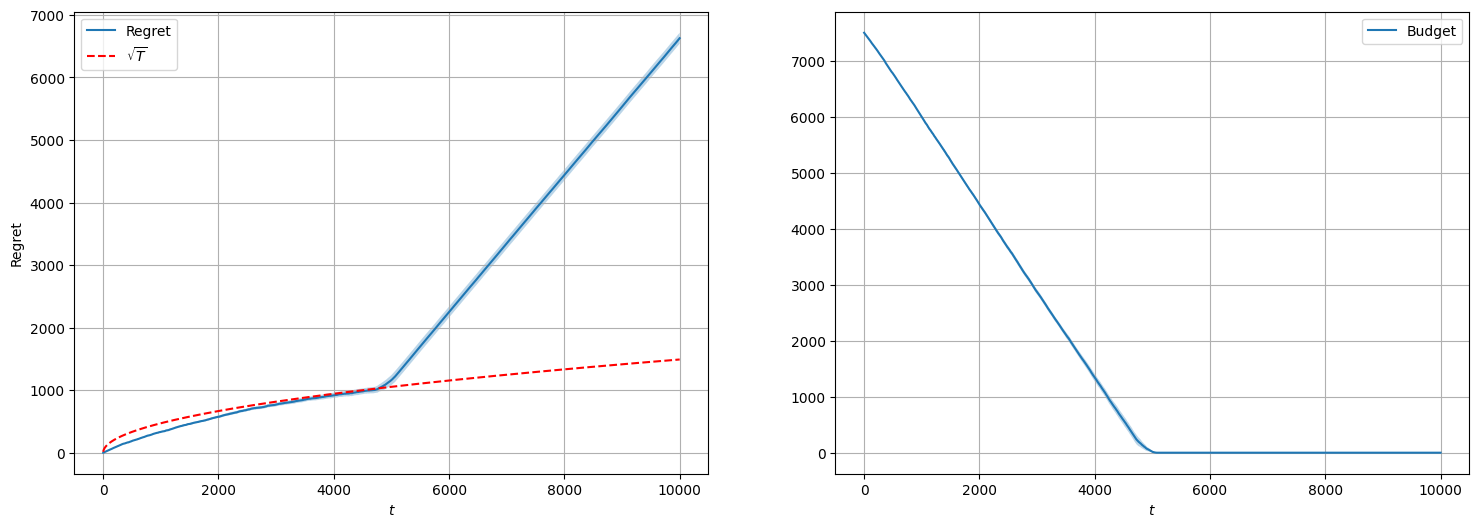

In [126]:
t = np.arange(1, T + 1)
theoretical_curve = (1000/np.sqrt(4500*np.log(K)))*np.sqrt(t*np.log(K))

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

# Regret plot
axs[0].plot(t, average_regret, label="Regret")
axs[0].fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
)
axs[0].plot(t, theoretical_curve, label="$\sqrt{T}$", linestyle="--", color="red")
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("Regret")
axs[0].legend()
axs[0].grid(True)

# Budget plot
axs[1].plot(np.arange(T), average_budget, label="Budget")
axs[1].fill_between(
    np.arange(T),
    average_budget-budget_sd/np.sqrt(n_trials),
    average_budget+budget_sd/np.sqrt(n_trials),
    alpha=0.3,
)
axs[1].set_xlabel("$t$")
axs[1].legend()
axs[1].grid(True)

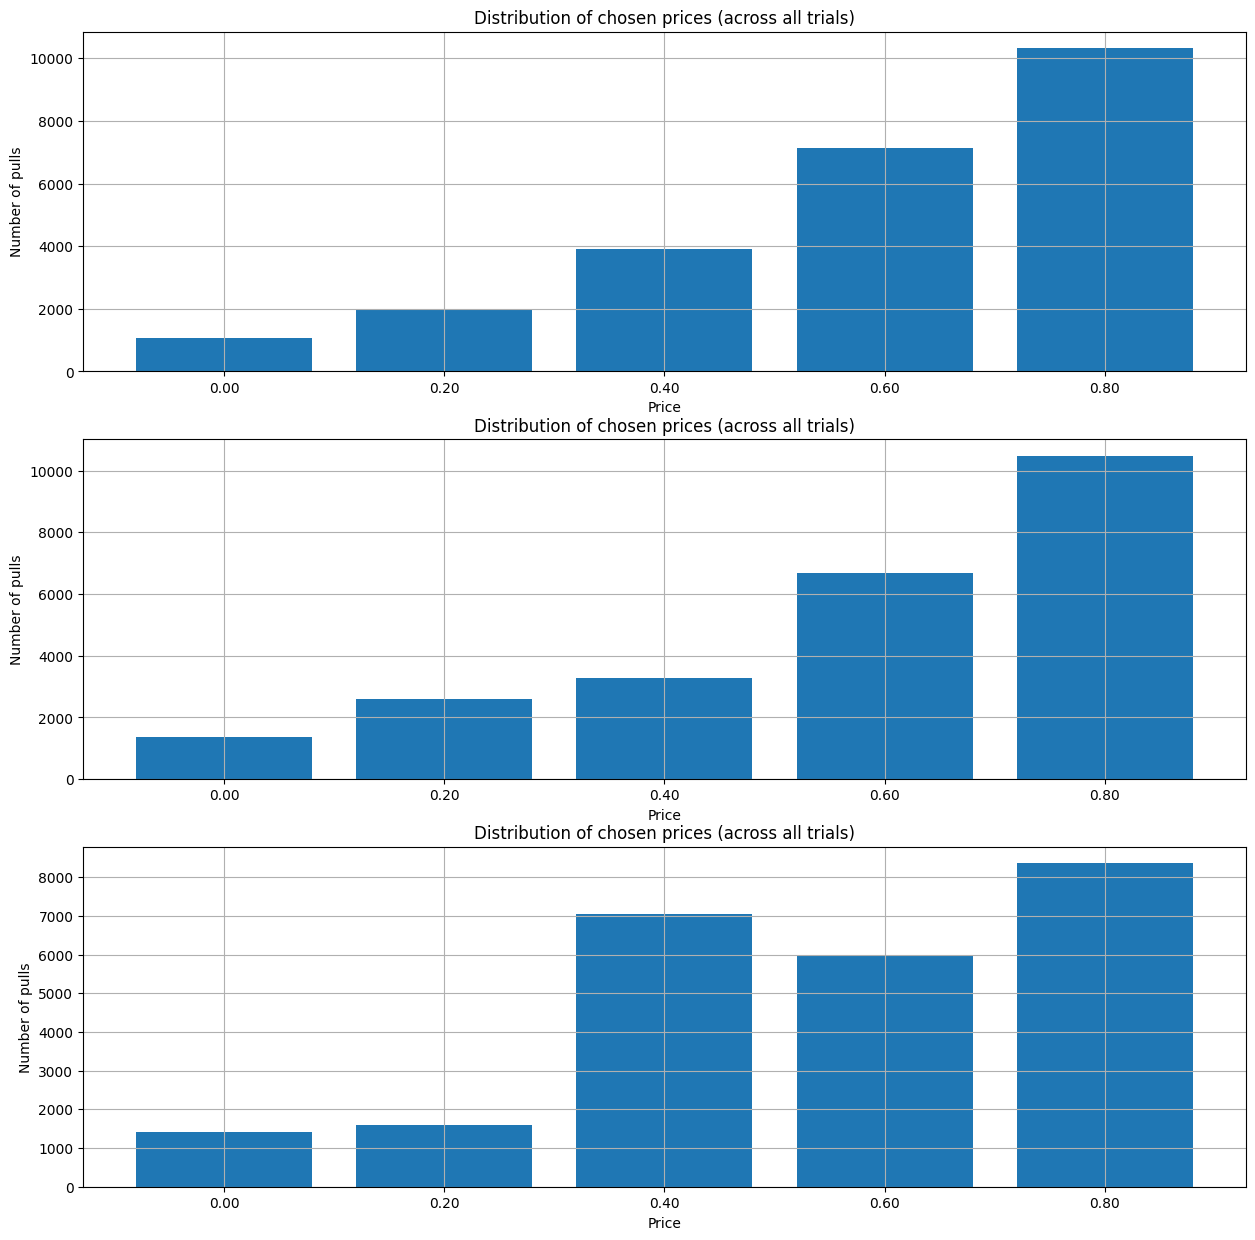

In [127]:
from collections import Counter

fig, axs = plt.subplots(N, 1, figsize=(15, 15))

prices_arr = np.array(prices_arr)
for i in range(N):
    price_counts = Counter(prices_arr[:, i])
    sorted_prices = sorted(price_counts)
    counts = [price_counts[p] for p in sorted_prices]

    axs[i].bar([f"{p:.2f}" for p in sorted_prices], counts)
    axs[i].set_xlabel("Price")
    axs[i].set_ylabel("Number of pulls")
    axs[i].set_title("Distribution of chosen prices (across all trials)")
    axs[i].grid(True)

### Execution - Stationary environment

In [128]:
#Stationary environment
valuation_distributions = []

mean_t = np.random.uniform(0.4, 1.0, size=N)
A = np.random.rand(N, N)
cov_t = np.dot(A, A.T) + 0.05 * np.eye(N)
distr = stats.multivariate_normal(mean=mean_t, cov=cov_t)
for t in range(T):
    valuation_distributions.append(distr)

In [129]:
# Run clairvoyant
clairvoyant=WindowedMultipleProductHighlyNonStationaryClairvoyant(T, B, N, prices, valuation_distributions, window_size=20)
expected_clairvoyant_utilities = clairvoyant.run()

In [130]:
prices_arr = []
rewards = []
budget_per_trial = []
regret_per_trial = []
n_trials = 5
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductHighlyNonStationaryEnvironment(T, N, valuation_distributions)
  multiplicative_pacing_agent = MultipleProductMultiplicativePacingAgent(prices, B, T, N, eta, learning_rate)
  count = 0
  agent_rewards = []
  budget=[]
  for t in range(T):
    if(count>=B):
      r_t = 0
      agent_rewards.append(np.sum(r_t))
    else:
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      prices_arr.append(p_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)

      agent_rewards.append(np.sum(r_t))
      count += np.sum(r_t > 0)
    budget.append(multiplicative_pacing_agent.get_budget())
  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)
  budget_per_trial.append(budget)

regret_per_trial = np.array(regret_per_trial)
budget_per_trial = np.array(budget_per_trial)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation
average_budget = np.array(budget_per_trial).mean(axis=0)
budget_sd = np.array(budget_per_trial).std(axis=0)

### Results

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_88769/1684471633.py:14: SyntaxWarning: invalid escape sequence '\s'
  axs[0].plot(t, theoretical_curve, label="$\sqrt{T}$", linestyle="--", color="red")


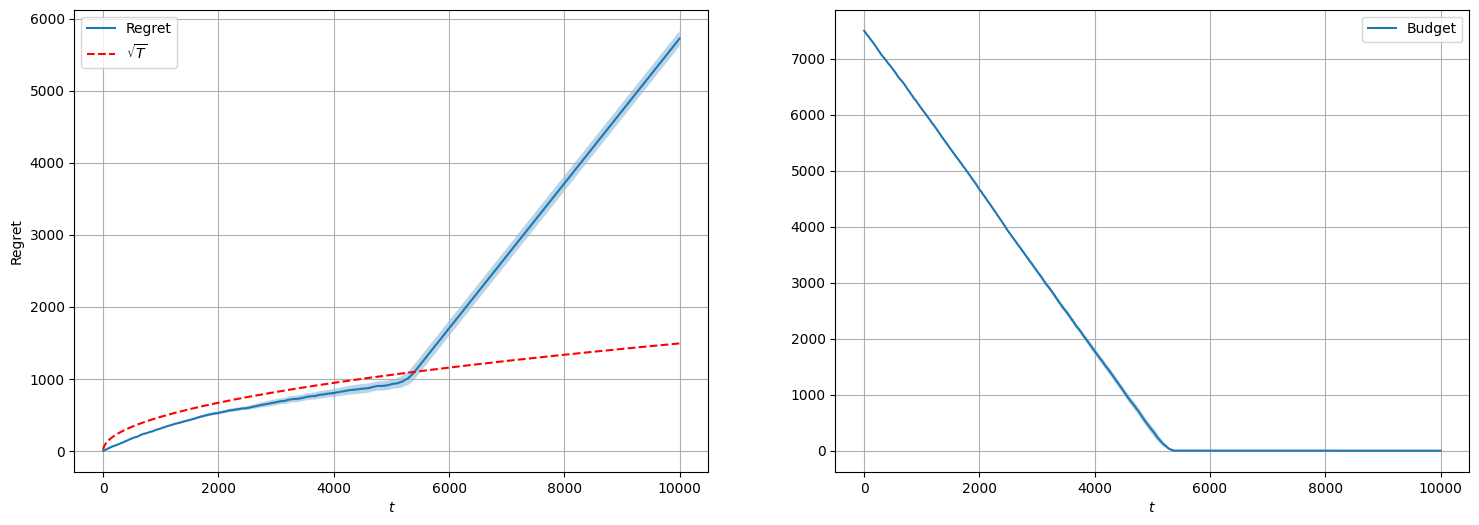

In [131]:
t = np.arange(1, T + 1)
theoretical_curve = (1000/np.sqrt(4500*np.log(K)))*np.sqrt(t*np.log(K))

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

# Regret plot
axs[0].plot(t, average_regret, label="Regret")
axs[0].fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
)
axs[0].plot(t, theoretical_curve, label="$\sqrt{T}$", linestyle="--", color="red")
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("Regret")
axs[0].legend()
axs[0].grid(True)

# Budget plot
axs[1].plot(np.arange(T), average_budget, label="Budget")
axs[1].fill_between(
    np.arange(T),
    average_budget-budget_sd/np.sqrt(n_trials),
    average_budget+budget_sd/np.sqrt(n_trials),
    alpha=0.3,
)
axs[1].set_xlabel("$t$")
axs[1].legend()
axs[1].grid(True)

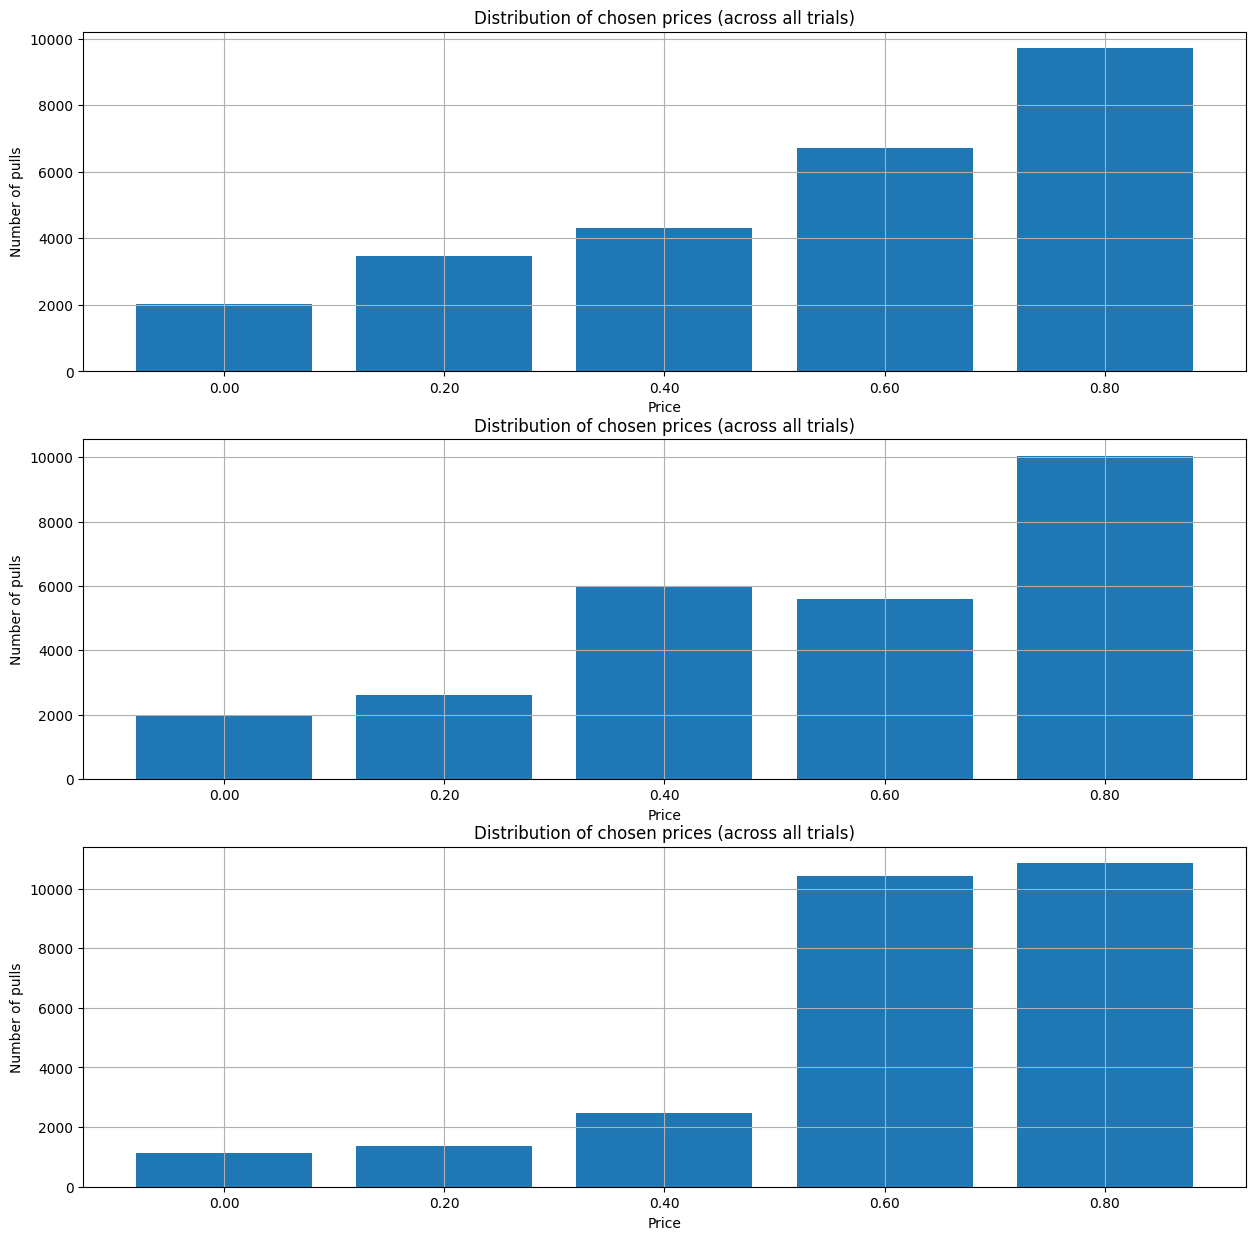

In [132]:
from collections import Counter

fig, axs = plt.subplots(N, 1, figsize=(15, 15))

prices_arr = np.array(prices_arr)
for i in range(N):
    price_counts = Counter(prices_arr[:, i])
    sorted_prices = sorted(price_counts)
    counts = [price_counts[p] for p in sorted_prices]

    axs[i].bar([f"{p:.2f}" for p in sorted_prices], counts)
    axs[i].set_xlabel("Price")
    axs[i].set_ylabel("Number of pulls")
    axs[i].set_title("Distribution of chosen prices (across all trials)")
    axs[i].grid(True)